# Unit 2 - Applied PCA
In this practical you will learn:
* Python idioms for 
 * plotting with matplotlib,
 * array addressing with numpy,
* The general scikit-learn workflow
* Performing PCA with scikit-learn
* Essential Data analysis with PCA and scikit-learn

# 1. Python idioms used in this practical
We will start with a refresher of Python idioms that we use in this practical. You can skip this if you feel you are already deeply familiar with the concepts presented. Feel free to come back to this section in case any code is unclear. 

## 1.1 matplotlib idioms

### plotting with ax.plot(...)
Internally, matplotlib uses an `Axes` object to plot the data in. All plotting can be done via methods of this object. to This object has all the methods one needs for plotting. In addition, it allows to adjust the plot appearance, add labels, etc.

Therefore it is often practical to plot via the `Axes` object rather than using e.g. `plt.plot(...)`

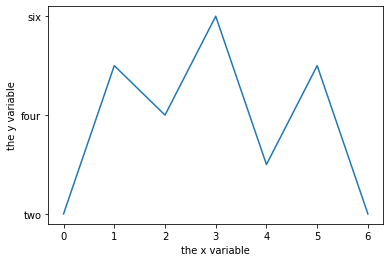

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.gca() #obtains the Axes object
ax.plot([2,5,4,6,3,5,2])

#decorate the plot; set axis labels 
t = ax.set_xlabel('the x variable')
t = ax.set_ylabel('the y variable')

#manually set ticks on the y-axis
t = ax.set_yticks([2,4,6])

# manually set labels
t =  ax.set_yticklabels(['two', 'four', 'six'])

Matplotlib can display square matrices as images via the `imshow` function. A `colorbar` alongside the figure acts as a kind of 'legend' that allows to guess numerical values from the colours. 

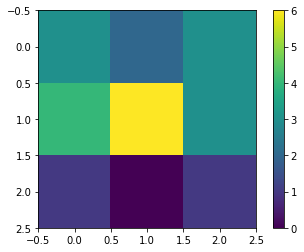

In [2]:
import numpy as np
ax = plt.gca()
matrix = np.array([[3,2,3],
                   [4,6,3],
                   [1,0,1]])
img = ax.imshow(matrix)
c = plt.colorbar(img) #note that this needs to be done via `plt`, not `ax`

## 1.2 numpy idioms
This is essential numpy you will need. Let's use a [Pascal matrix](https://en.wikipedia.org/wiki/Pascal_matrix) as an example: 

In [3]:
from scipy.linalg import pascal

#make pascal matrix, 5 rows, 5 columns
p = pascal(5)
#slice parts of it to make it non symmetric
p=p[1:4,:]
p

array([[ 1,  2,  3,  4,  5],
       [ 1,  3,  6, 10, 15],
       [ 1,  4, 10, 20, 35]], dtype=uint64)

### mean, standard deviation, variance in arrays and matrices
You can compute mean, standard deviation and variance with numpy via `mean`, `std` and `var`. Normally these 'flatten' the array and return only one number:

In [4]:
np.mean(p)

8.0

But you can compute them separately for each column...

In [5]:
np.mean(p, axis=0)

array([ 1.        ,  3.        ,  6.33333333, 11.33333333, 18.33333333])

... or for each row:

In [6]:
np.mean(p, axis=1)

array([ 3.,  7., 14.])

We mostly compute them separately for each column, as we are interested in mean and variance of features.

In [7]:
np.std(p, axis=0)

array([ 0.        ,  0.81649658,  2.86744176,  6.59966329, 12.47219129])

In [8]:
np.var(p, axis=0)

array([  0.        ,   0.66666667,   8.22222222,  43.55555556,
       155.55555556])

### Slicing via the `:` operator 
Quite often we will only want to use parts of an array. This is accomplished by 'slicing' via the `:` operator. By itself, it selects all values in one dimension:

In [9]:
p[2,:] # all columns in row two. counting starts at zero!

array([ 1,  4, 10, 20, 35], dtype=uint64)

In [10]:
p[:,1] # all rows in column 1. 

array([2, 3, 4], dtype=uint64)

Notice that a column is selected, but the resulting array is printed as a row!

The `:` operator can be used to select ranges of data:

In [11]:
p[2:4, 3:5] # data in rows 2 and 3, and columns 3 and 4 

array([[20, 35]], dtype=uint64)

### array indexing with booleans
You can apply a criterion to a range of values and use the resulting boolean array to address the columns and rows. 

For example, lets check which columns have variance larger than 8.0:

In [12]:
cols = np.var(p, axis=0) > 8.0
cols

array([False, False,  True,  True,  True])

We can use this to select those columns from the array:

In [13]:
p[:, cols]

array([[ 3,  4,  5],
       [ 6, 10, 15],
       [10, 20, 35]], dtype=uint64)

Of course array contents can be addressed with numerical indices, too:

In [14]:
p[:, [2,3,4]] #selects columns 2,3,4 

array([[ 3,  4,  5],
       [ 6, 10, 15],
       [10, 20, 35]], dtype=uint64)

### boolean arithmetics for indexing
Boolean index arrays can be combined using boolean arithmetics. For example, consider the following array:

In [15]:
a = np.array([3,7,5,8,6,2,1,9,4,5,7,8,2,3,6,4,7,8,3,4,5])

Lets place a criterion that values should be greater than 3:

In [16]:
gt3 = a > 3
gt3

array([False,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False,  True,  True])

In addition, values should be smaller than 8:

In [17]:
lt8 = a < 8
lt8

array([ True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True])

Finally, let's combine those two criteria using the boolean 'and':

In [18]:
crit = np.logical_and(lt8,gt3)
crit

array([False,  True,  True, False,  True, False, False, False,  True,
        True,  True, False, False, False,  True,  True,  True, False,
       False,  True,  True])

... and we can finally select those values from the array which are greater than 3 and less than 8:

In [19]:
a[crit]

array([7, 5, 6, 4, 5, 7, 6, 4, 7, 4, 5])

## 1.3 sklearn general workflow
Scikit-learn provides machine learning algorithms, called *estimators*, and transformers and preprocessors (like to normalise data.  All of these support a `fit` and a `transform` method. 
* `fit` 'trains' the machine learning model, or extracts the parameters for the preprocessor.
* `transform` applies the learnt model or parameterised preprocessing to the data.
    
For example, the `StandardScaler` that scales a features matrix to zero mean and unit variance.

Let's look at the pascal matrix as an example again, this time using the "upper triangular' form:

In [20]:
p = pascal(3, 'upper', exact=False) 
#exact=False creates a floating point instead of an int array
#avoids an error message further down.

print('before scaling:')
print(p)
print('per-column mean:')
print('{}'.format(np.mean(p, axis=0)))
print('per-column variance:')
print('{}'.format(np.var(p, axis=0)))

before scaling:
[[1. 1. 1.]
 [0. 1. 2.]
 [0. 0. 1.]]
per-column mean:
[0.33333333 0.66666667 1.33333333]
per-column variance:
[0.22222222 0.22222222 0.22222222]


Now we use `StandardScaler` to scale the matrix:

In [21]:
from sklearn import preprocessing as pp
# sklearn standard scaler in action
scaler = pp.StandardScaler()
scaler.fit(p) # 'learns' mean and variance of a
p_dash = scaler.transform(p) # 'transforms' a

print()
print('after scaling:')
print(p_dash)
print('per-column mean:')
print('{}'.format(np.mean(p_dash, axis=0)))
print('per-column variance:')
print('{}'.format(np.var(p_dash, axis=0)))


after scaling:
[[ 1.41421356  0.70710678 -0.70710678]
 [-0.70710678  0.70710678  1.41421356]
 [-0.70710678 -1.41421356 -0.70710678]]
per-column mean:
[7.40148683e-17 7.40148683e-17 1.48029737e-16]
per-column variance:
[1. 1. 1.]


Note how the normalised mean is vanishingly small. 

# 2. PCA essentials 

Let's do a PCA on an anisotropic gaussian blob of data points. 

First we make the data and plot it. We use the `multivariate_normal` function of nupy that generates a gaussian blob with a given covariance matrix - very convenient!

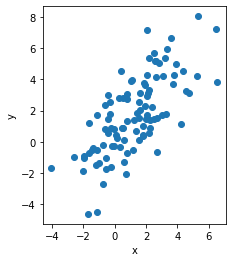

In [22]:
design_covmat = np.array([[5.,4.],
                          [4.,6.]]) #the covariance matrix
center = np.array([1,1.5]) # the center of the blob
blob = np.random.multivariate_normal(mean=center, 
                                     cov=design_covmat, 
                                     size=100)

#plotting
ax = plt.gca()
ax.scatter(blob[:,0], blob[:,1])
ax.axis('scaled')
t = ax.set_xlabel('x')
t = ax.set_ylabel('y')

Next step: do a PCA with scikit-learn.

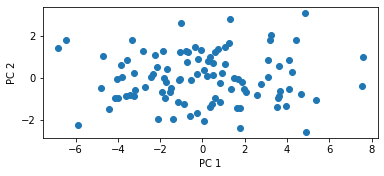

In [23]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(blob)
blob_pca = pca.transform(blob)

#plotting
ax = plt.gca()
ax.scatter(blob_pca[:,0], blob_pca[:,1])
ax.axis('scaled')
t = ax.set_xlabel('PC 1')
t = ax.set_ylabel('PC 2')

Notice two things:
1. the center of the blob is now at the origin ([0.,0.])
2. the first component (i.e. x-axis) is aligned in the direction of highest variance. 

### Covariance matrix from PCA
The PCA implementation in scikit-learn gives us access to the covariance matrix. Let's compare it to the covariance matrix that we used to make the blobs:

In [24]:
computed_covmat = pca.get_covariance()
print("covmat from PCA:")
print("{}".format(computed_covmat))
print()
print("design covmat:")
print("{}".format(design_covmat))


covmat from PCA:
[[4.01469246 3.54866308]
 [3.54866308 6.23606224]]

design covmat:
[[5. 4.]
 [4. 6.]]


**Question 1 and 2:**

* Are the design and the computed covariance matrices identical? 
- `No they are not identical but they have almost same values`

* If not, why? What does it mean for using PCA in applied data analysis?
- `This occurs during computation of the convariance matrix (compute convariance) which gives how variable or spread the array is between selected points while for Design, centers were selected randomly which affects the spread of the dataset within these`.

**Task 1**
* Increase the number of points in the blob from 100 to 10000. Repeat the analysis. How large is the difference between the observed and design covariance matrix now? Can you explain the difference to the previous example with the 100 points in the blob?


- `Computed variance for 100 points and 10000 points is same and has no difference. Here we are using the same center to create a normally distributed data points hence their mean will not change thus causing no change in variance.  Using multivariate_normal and  center =[1,1.5] with covariance matrix of [[5,4], [4,6]] which does not change in both cases hence datapoints generated will have similar variability about the mean given.`

In [25]:
design_covmat = np.array([[5.,4.],
                          [4.,6.]])
center = np.array([1,1.5]) 
blob = np.random.multivariate_normal(mean=center, 
                                     cov=design_covmat, 
                                     size=10000)

computed_covmat = pca.get_covariance()
print("covmat from PCA:")
print("{}".format(computed_covmat))
print()
print("design covmat:")
print("{}".format(design_covmat))

covmat from PCA:
[[4.01469246 3.54866308]
 [3.54866308 6.23606224]]

design covmat:
[[5. 4.]
 [4. 6.]]


## 2.1 PCA on iris

We're just warming up so let's reproduce the Iris analysis from the lecture. 

We start by loading the iris data set, which is conveniently contained in scikit-learn:

In [26]:
import sklearn.datasets as data
iris = data.load_iris()

The result is a data structure, in the form of a dictionary. let's explore it:

In [27]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

The names of the keys are pretty much self-explanatory. Have a look at the `DESCR` key for more information about the data set:

In [28]:
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

We can construct a pandas data frame from that information:

In [29]:
import pandas as pd
iris_df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
iris_df['species'] = iris['target']
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### **Task 2:**
Construct the data frame such that the "species" column has the actual species names (setosa etc).

### PCA on iris

We can essentially use the same approach when out data is in a data frame, we just have to get it out:

In [30]:
# create a new dataframe that will name the species with their actual name
new_df = iris_df.copy()

In [31]:
# get the actual target names
new_df['species'] = new_df['species'].apply(lambda x: iris.target_names[x])

In [32]:
# check sample head

new_df.sample(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
104,6.5,3.0,5.8,2.2,virginica
35,5.0,3.2,1.2,0.2,setosa
75,6.6,3.0,4.4,1.4,versicolor
56,6.3,3.3,4.7,1.6,versicolor
40,5.0,3.5,1.3,0.3,setosa
20,5.4,3.4,1.7,0.2,setosa
55,5.7,2.8,4.5,1.3,versicolor
136,6.3,3.4,5.6,2.4,virginica
115,6.4,3.2,5.3,2.3,virginica
96,5.7,2.9,4.2,1.3,versicolor


In [33]:
iris_values = iris_df[iris['feature_names']].values
iris_values

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

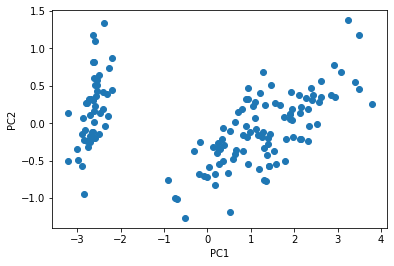

In [34]:
pca = PCA()
pca.fit(iris_values)
iris_pca = pca.transform(iris_values)

#plotting
ax = plt.gca()
ax.scatter(iris_pca[:,0], iris_pca[:,1])
t = ax.set_xlabel('PC1')
t = ax.set_ylabel('PC2')

**Task 3:** color the dots according to species.

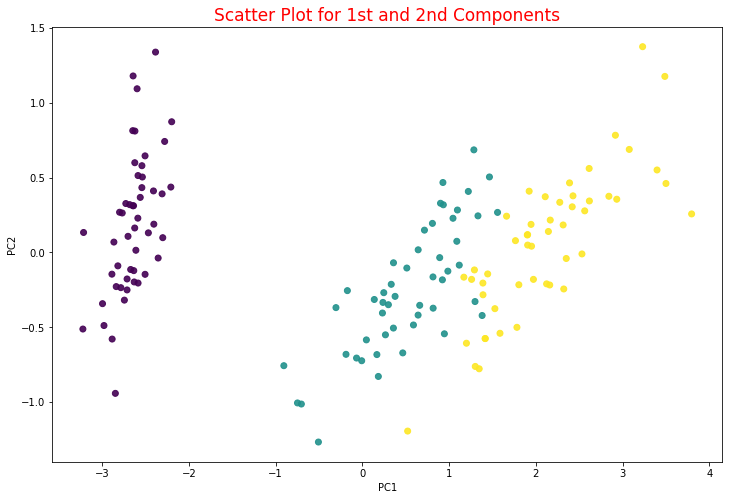

In [35]:
# coloring the dots

#plotting
plt.figure(figsize=(12,8))
ax = plt.gca()
plt.title("Scatter Plot for 1st and 2nd Components", fontsize=17,c='r')
ax.scatter(iris_pca[:,0], iris_pca[:,1], cmap='viridis', alpha=0.9, c=iris_df['species'])
t = ax.set_xlabel('PC1')
t = ax.set_ylabel('PC2')

### covariance matrix
Let's plot the covariance matrix as numbers:

In [36]:
pca.get_covariance()

array([[ 0.68569351, -0.042434  ,  1.27431544,  0.51627069],
       [-0.042434  ,  0.18997942, -0.32965638, -0.12163937],
       [ 1.27431544, -0.32965638,  3.11627785,  1.2956094 ],
       [ 0.51627069, -0.12163937,  1.2956094 ,  0.58100626]])

Now let's plot the covariance matrix as an image:

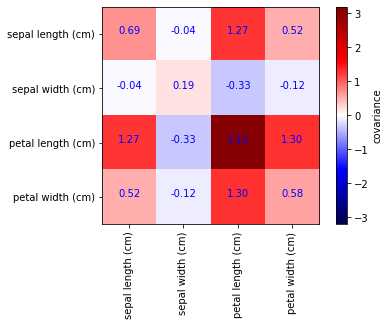

In [37]:
ax = plt.gca()
covmat = pca.get_covariance()
img = ax.imshow(covmat, cmap='seismic', vmin=-3.2, vmax=3.2)
plt.colorbar(img, label='covariance')
ax.set_yticks([0,1,2,3])
t = ax.set_yticklabels(iris['feature_names'])
ax.set_xticks([0,1,2,3])
t = ax.set_xticklabels(iris['feature_names'], rotation=90)
for x in range(4):
    for y in range(4):
        ax.text(x,y,"{:.2f}".format(covmat[y,x]), {'ha':'center', 'color':"blue"})

In the practicals to follow, we will often visualise matrices as "images", with a colorbar that reveals the numerical value. Usually we will not plot the actual values, resulting in such a plot:

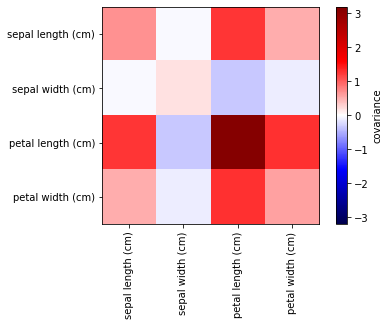

In [38]:
ax = plt.gca()
img = ax.imshow(covmat, cmap='seismic', vmin=-3.2, vmax=3.2)
plt.colorbar(img, label='covariance')
ax.set_yticks([0,1,2,3])
ax.set_yticks([0,1,2,3])
t = ax.set_yticklabels(iris['feature_names'])
ax.set_xticks([0,1,2,3])
t = ax.set_xticklabels(iris['feature_names'], rotation=90)


### Scree plot
The scree plot displays the amount of explained variance.

[Text(0, 0, 'PC0'), Text(1, 0, 'PC1'), Text(2, 0, 'PC2'), Text(3, 0, 'PC3')]

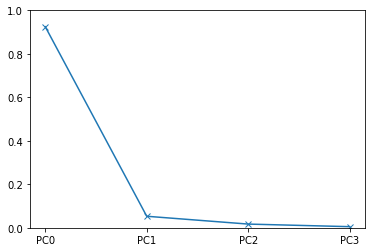

In [39]:
ax = plt.gca()
expl_var = pca.explained_variance_ratio_
ax.plot(expl_var, marker='x')
ax.set_ylim(0,1.)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["PC{}".format(i) for i in range(4)])

### Components
The principal components are a weighted sum of the data vectors. Let's retrieve them from the PCA:

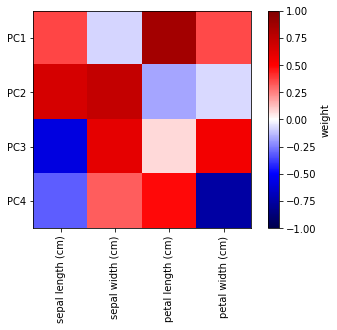

In [40]:
comps = pca.components_
ax = plt.gca()
img = ax.imshow(comps, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar(img, label="weight")
ax.set_yticks([0,1,2,3])
t = ax.set_yticklabels(["PC{}".format(i+1) for i in range(4)])
ax.set_xticks([0,1,2,3])
t = ax.set_xticklabels(iris['feature_names'], rotation=90)

**Task 4**: Which features have a positive weight on PC1?

- `The features with positive weights will be checked against the coloring of the box. In this case PETAL LENGTH(CM) has the most positive weight followied by SEPAL Lenght(CM) 0n PC1 and finally petal width(cm)`

### Normalisation
Finally, let's normalise the data and do the PCA again:

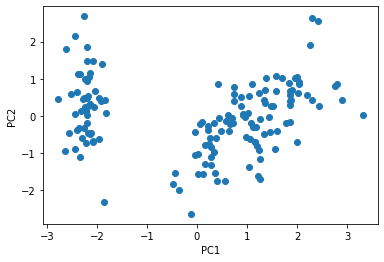

In [41]:
ss = pp.StandardScaler()
ss.fit(iris_values)
pca_norm = PCA()
pca_norm.fit(ss.transform(iris_values)) # note the composition of the commands
iris_pca_norm = pca_norm.transform(ss.transform(iris_values))

#plotting
ax = plt.gca()
ax.scatter(iris_pca_norm[:,0], iris_pca_norm[:,1])
t = ax.set_xlabel('PC1')
t = ax.set_ylabel('PC2')

The difference in result is subtle in the plot of the first two PCs, but it is more drastic in the covariance matrix.

### Task 5, putting it all together:
1. plot the covariance matrix for the normalised data and compare it to that of the raw data.
2. plot the scree-plot for the normalised data and compare it to that of the raw data. 
3. Observe the difference! Compare to the lecture, where we discussed the "variance bug" of PCA.



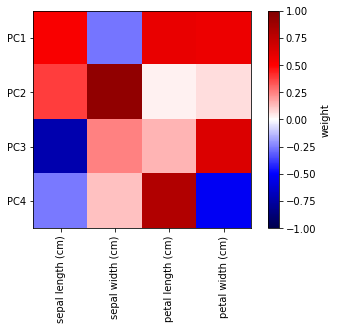

In [42]:
# 1. plot the covariance matrix for the normalised data and compare it to that of the raw data.

comps = pca_norm.components_
ax = plt.gca()
img = ax.imshow(comps, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar(img, label="weight")
ax.set_yticks([0,1,2,3])
t = ax.set_yticklabels(["PC{}".format(i+1) for i in range(4)])
ax.set_xticks([0,1,2,3])
t = ax.set_xticklabels(iris['feature_names'], rotation=90)

[Text(0, 0, 'PC0'), Text(1, 0, 'PC1'), Text(2, 0, 'PC2'), Text(3, 0, 'PC3')]

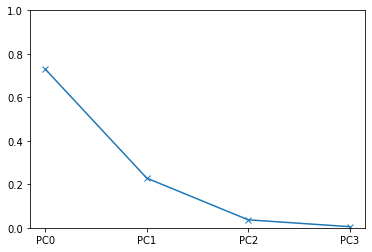

In [43]:
# 2. plot the scree-plot for the normalised data and compare it to that of the raw data.

ax = plt.gca()
expl_var = pca_norm.explained_variance_ratio_
ax.plot(expl_var, marker='x')
ax.set_ylim(0,1.)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["PC{}".format(i) for i in range(4)])

In [44]:
# Observe the difference! Compare to the lecture, where we discussed the "variance bug" of PCA.

In [45]:
iris_pca_covmat = pca.get_covariance()
iris_pca_covmat_norm = pca_norm.get_covariance()

In [46]:
iris_pca_covmat

array([[ 0.68569351, -0.042434  ,  1.27431544,  0.51627069],
       [-0.042434  ,  0.18997942, -0.32965638, -0.12163937],
       [ 1.27431544, -0.32965638,  3.11627785,  1.2956094 ],
       [ 0.51627069, -0.12163937,  1.2956094 ,  0.58100626]])

In [47]:
iris_pca_covmat_norm

array([[ 1.00671141, -0.11835884,  0.87760447,  0.82343066],
       [-0.11835884,  1.00671141, -0.43131554, -0.36858315],
       [ 0.87760447, -0.43131554,  1.00671141,  0.96932762],
       [ 0.82343066, -0.36858315,  0.96932762,  1.00671141]])

`Normalized covmat is more towards zero unlike unnormalized which has large values.`

# Conclusion
* PCA is a powerful tool to get a first glance at data. 
* Normalisation can make a huge difference.
* Dimensionality reduction helps with plotting.
* Scree plot allows to identify how many components are required.
* Component loadings allow interpretation of feature relevance.
* Identifying clusters can help uncover patterns in instances and features. 